In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


 best_circle_imgs
'best_circle_imgs (256color_faulty_lowerclip)'
'best_circle_imgs (256gray)'
'best_circle_imgs (copy)'
 best_so_far.png
 best_X_imgs
'download (1).png'
'download (2).png'
'download (3).png'
'download (4).png'
'download (5).png'
 download.png
 last_population_11k_with_sigmas.npy
 last_population_30k_with_sigmas.npy
 last_population.npy
 last_sigmas_11k.npy
 last_sigmas_30k.npy
 last_sigmas.npy
 Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg
 population_30k_kindaok.npy
 population_background.npy
 population_continuation_with_sigmas.npy
 population.npy
 projekt.ipynb
 projekt.ipynb.invalid
 README.md
 result_30k.png
 sigmas_continuation_with_sigmas.npy
 sigmas.npy
 todo.txt


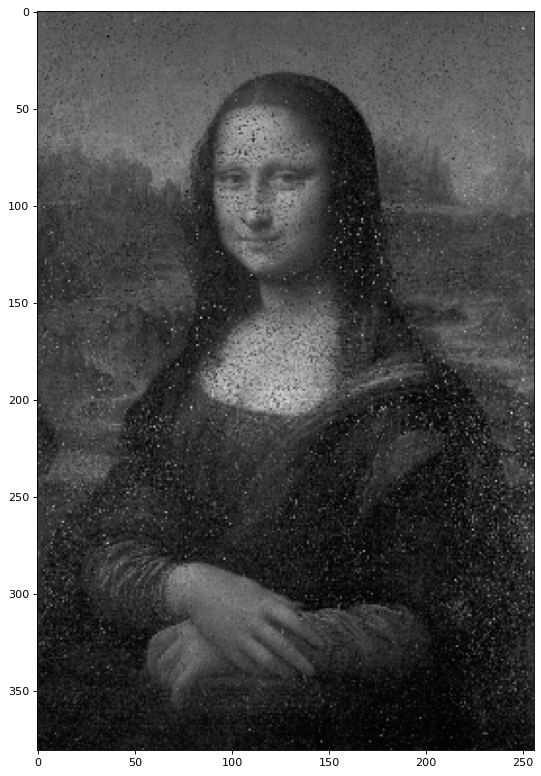

In [49]:
resize_to=256
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
target_img=target_img[300:-400, 300:-300] # cut borders

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255


figure(figsize=(16, 12), dpi=80)
plt.imshow(target_img, cmap='gray')
plt.show()

In [50]:
target_img.shape

(381, 256)

# ES

In [51]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_circle_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [52]:
class EvoulationStrategy:
    def __init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
        
        self.chromosome_length=initial_chromosome_length
        self.initial_chromosome_length=initial_chromosome_length
        self.genotype_length=genotype_length
        self.population_size=population_size
    
        self.target_img=target_img
        self.max_radius=np.sqrt(pow(self.target_img.shape[0],2)+pow(self.target_img.shape[1], 2))/2
        self.gray=gray
    
        self.population=None#np.empty((self.population_size, self.initil_chromosome_length, self.genotype_length))
        # circles already in good position, modify only those in self.population
        # preferably array representing image, to save time during eval
        self.population_background=None 
        self.sigmas=None#np.empty((self.population_size, self.genotype_length))
        self.curr_iter=0
        self.evals=None
        self.times_circles_were_added=0
        
        self.mutation_clip_lows=np.zeros(genotype_length)
      #  clip_highs=np.ones(solutions[i].shape[1])
        self.mutation_clip_lows[2]=2/self.target_img.shape[1] # minimal radius
        self.mutation_clip_lows[3]=1/256 # miniaml opacity
        
    def random_circle(self, max_radius_scale=1.0, max_opacity_scale=1.0,
                      x_min=0, x_max=1, y_min=0, y_max=1):
        if self.gray:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
        else:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
            
        lows[0]=x_min
        highs[0]=x_max
        lows[1]=y_min
        highs[1]=y_max
        
        lows[2]=0.125*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale

        circle=np.random.uniform(lows, highs, self.genotype_length)
        return circle

    def random_individual(self, chrom_length, max_radius_scale=1.0,  max_opacity_scale=1.0,
                          x_min=0, x_max=1, y_min=0, y_max=1):
        indiv = np.zeros((chrom_length, self.genotype_length))

        for i in range(chrom_length):
            indiv[i] = self.random_circle(max_radius_scale, 
                                          max_opacity_scale,
                                          x_min, x_max, 
                                          y_min, y_max)
        return indiv

    def random_population(self, chrom_length,
                          max_radius_scale=1.0, max_opacity_scale=1.0,
                          x_mins=[0], x_maxs=[1], y_mins=[0], y_maxs=[1]
                         ):
        population = np.zeros((self.population_size, chrom_length, self.genotype_length))
        if len(x_mins)==1:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[0], x_maxs[0], y_mins[0], y_maxs[0])
        else:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[i], x_maxs[i], y_mins[i], y_maxs[i])
        return population

    def represent_individual(self, X, X_img=None):
        if isinstance(X_img, type(None)): 
            X_img=np.zeros(self.target_img.shape)
        for c in X:
            #[x, y, radius, opacity, r, g, b]
            x=int(c[0]*self.target_img.shape[1])
            y=int(c[1]*self.target_img.shape[0])
            radius=int(c[2]*self.max_radius)
            opacity=c[3]
            rgb=c[4:]
            circle_img=cv2.circle(X_img.copy(), 
                                  (x, y), 
                                  radius, 
                                  rgb,
                                  thickness=-1)
            X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
        return X_img
    
    def f(self, X_img, target=None):
        if isinstance(target, type(None)):
            target=self.target_img
        #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
        pom = target - X_img
        return np.sum(pom*pom)
    
    def evaluate_individual(self, solutions, background, evals, i):
        evals[i]=self.f(self.represent_individual(solutions[i], background[i].copy()))
    def get_region_for_individual(self, i, no_split=4, targets=None):
        '''
        returns (upper left, lower right) points for part of image with the highest MSE  
        '''
        X=self.represent_individual(self.population[i], self.population_background[i].copy())

        # split into rows
        pom=np.array_split(X, no_split, axis=0)
        # split rows into cols
        pom=[np.array_split(p, no_split, axis=1) for p in pom]
        Xs=[]
        y=0
        for  po in (pom):
            x=0
            for  p in (po):
                Xs.append((p, 
                           (x, y), 
                           (x+p.shape[1], y+p.shape[0])))
                x+=p.shape[1]
            y+=po[0].shape[0]
            
        evals=np.asarray([self.f(X_part[0], target_part) for X_part, target_part in zip(Xs, targets)])
      #  print(evals)
        fitness_values = evals - evals.min() + 1e-10
        fitness_values = fitness_values / fitness_values.sum()
        idx = np.random.choice(no_split*no_split, 1, True, fitness_values).item()
        return Xs[idx][1], Xs[idx][2]
        
    def mutate_X(self, X, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)

        X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                             X.shape[1]))-0.5)*sigmas, 
                                     self.self.mutation_clip_lows, 1)
        return X

    def mutate_sigmas(self, sigmas, scale=1e-3, mut_prob=0.5):
        mutation_indices = (np.random.random(sigmas.shape) < mut_prob).astype(float)
        sigmas += mutation_indices * np.random.normal(loc=0, scale=scale, size=sigmas.shape)
        sigmas= np.clip(sigmas, 1e-5, 1e-1)
        return sigmas

    def mutate_X_thred(self, solutions, i, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)

        solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((
                                                                   no_figures_to_mutate,
                                                                   solutions[i].shape[1]))-0.5)*sigmas[i], 
                                               self.mutation_clip_lows, 1)

    def train(self,
            number_of_iterations=30000, 
            number_of_parents=6, 
            number_of_offspring_per_parent=3, 
            max_chromosome_length=256,
            initial_sigma_scale=5e-2,
            add_cricle_threshold=5e-3,
            log_frequency=1,
            update_frequency=100,
            no_added_circels=1,
            pararell=True
        ):
        best_solution = np.zeros((max_chromosome_length, self.genotype_length))
        best_solution_background = np.zeros(self.target_img.shape)
        best_solution_objective_value = np.inf


        log_objective_values = np.zeros((number_of_iterations, 4))
        log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
        log_best_backgrounds = []
        log_sigmas_mean=np.zeros((number_of_iterations, self.genotype_length))
       # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

        # generating an initial population
        if not isinstance(self.population, np.ndarray):
            self.population=self.random_population(self.chromosome_length)
        if not isinstance(self.population_background, np.ndarray):
            self.population_background=np.zeros((self.population_size, *self.target_img.shape))
        # SIGMAS individualXcircle parameters (mutation scale)
        if not isinstance(self.sigmas, np.ndarray):
            self.sigmas = initial_sigma_scale * np.ones((self.population_size, self.genotype_length))

        # evaluating the objective function on the current population
        self.evals=np.ones(self.population_size)
        if pararell:
            threads=[]
            for i in range(self.population_size):
                t=th.Thread(target=self.evaluate_individual, args=[self.population, self.population_background, self.evals, i])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

        try:
            #self.times_circles_were_added=0#1+self.population.shape[1]//(2*self.initial_chromosome_length) 
            # initial creation of population
            last_update_iter=0
            initial_no_split=2
           # start_mutations_scale=mutation_scale
            for no_iter in progress_bar(range(number_of_iterations)):
                self.curr_iter=no_iter
                # selecting the parent indices by the roulette wheel method
                # MAXIMIZE
                #fitness_values = self.evals - self.evals.min()
                # MINIMIZE
                fitness_values = self.evals.max() - self.evals
                if fitness_values.sum() > 0:
                    fitness_values = fitness_values / fitness_values.sum()
                else:
                    fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
                parent_indices = np.random.choice(self.population_size, 
                                                  number_of_parents, True, fitness_values).astype(np.int64)

                # creating the children population by Global Intermediere Recombination
                children_list=[]
                children_background_list=[]
                children_sigmas_list=[]
                for i in range(number_of_offspring_per_parent):
                    children_list.append(self.population[parent_indices].copy())          
                    children_background_list.append(self.population_background[parent_indices].copy())          
                    children_sigmas_list.append(self.sigmas[parent_indices].copy())          
                children_population_solutions = np.vstack(children_list)
                children_population_backgrounds = np.vstack(children_background_list)
                children_population_sigmas = np.vstack(children_sigmas_list)

                children_population_sigmas=self.mutate_sigmas(children_population_sigmas)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.mutate_X_thred, args=[children_population_solutions, 
                                                                      i, children_population_sigmas])
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    for i in range(children_population_solutions.shape[0]):
                        children_population_solutions[i]=self.mutate_X(children_population_solutions[i], 
                                                                  children_population_sigmas[i])

                # evaluating the objective function on the children population
                children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.evaluate_individual, args=[children_population_solutions,
                                                                           children_population_backgrounds,
                                                                           children_population_objective_values,
                                                                           i] )
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    children_population_objective_values = [self.f(self.represent_individual(X)) for X in children_population_solutions]

                # replacing the current population by (Mu + Lambda) Replacement
                self.evals = np.hstack([self.evals, 
                                        children_population_objective_values])
                self.population = np.vstack([self.population, 
                                             children_population_solutions])
                self.population_background = np.vstack([self.population_background, 
                                             children_population_backgrounds])
                self.sigmas = np.vstack([self.sigmas, 
                                         children_population_sigmas])

                I = np.argsort(self.evals)#[::-1]
                self.population = self.population[I[:self.population_size], :]
                self.population_background = self.population_background[I[:self.population_size], :]
                self.sigmas = self.sigmas[I[:self.population_size], :]
                self.evals = self.evals[I[:self.population_size]]

                # recording some statistics
                if best_solution_objective_value > self.evals[0]:
                    best_solution = self.population[0, :]
                    best_solution_background=self.population_background[0, :]
                    best_solution_objective_value = self.evals[0]

                log_objective_values[no_iter, :] = [self.evals.min(), 
                                                    self.evals.max(),
                                                    self.evals.mean(), 
                                                    self.evals.std()]
                log_sigmas_mean[no_iter, :] = np.mean(self.sigmas, axis=0)
                
                if np.mod(no_iter, update_frequency) == 0 and \
                   no_iter-last_update_iter>=update_frequency*2 and \
                   self.population.shape[1]<max_chromosome_length:

                        prev=np.mean(log_objective_values[no_iter-2*update_frequency:no_iter-update_frequency])
                        curr=np.mean(log_objective_values[no_iter-update_frequency:no_iter+1])
                        if (prev-curr)/prev < add_cricle_threshold*np.power(0.995, self.times_circles_were_added): # ADD CIRCLES

                            last_update_iter=no_iter
                            self.times_circles_were_added+=1
                            best_solution_objective_value=np.inf
                          #  mutation_scale=start_mutations_scale/self.times_circles_were_added

                            radius_scale=1/np.log2(1+self.times_circles_were_added*2)
                            if radius_scale<1/32:
                                radius_scale=1/32
                            no_split=np.power(initial_no_split, 
                                              int(np.floor(max(np.log(self.times_circles_were_added)-1, 1))))
                            if no_split>32:
                                no_split=32
                            print(f'''Adding circles {self.times_circles_were_added}th time. 
                                      \n Split target image into {no_split*no_split} rectangles.
                                      \n Radius_scale={radius_scale}''')
                   
                            #create new  circles
                            pom=np.array_split(self.target_img, no_split, axis=0)
                            # split rows into cols
                            pom=[np.array_split(p, no_split, axis=1) for p in pom]
                            targets=[]
                            for  po in (pom):
                                for  p in (po):
                                    targets.append(p)
                            
                            xmins=[]
                            ymins=[]
                            xmaxs=[]
                            ymaxs=[]
                            for idx in range(self.population_size):
                                # left upper, right lower  ((lu_x, lu_y),(rl_x, rl_y))
                                lu, rl=self.get_region_for_individual(idx, 
                                                                            no_split=no_split, 
                                                                            targets=targets)
                                xmins.append(lu[0]/self.target_img.shape[1])
                                ymins.append(lu[1]/self.target_img.shape[0])
                                xmaxs.append(rl[0]/self.target_img.shape[1])
                                ymaxs.append(rl[1]/self.target_img.shape[0])
                            
                            new_pop=self.random_population(chrom_length=no_added_circels, 
                                                           max_radius_scale=radius_scale,
                                                           max_opacity_scale=0.5,
                                                           x_mins=xmins, x_maxs=xmaxs,
                                                           y_mins=ymins, y_maxs=ymaxs
                                                          )

                            # save old circles in background, remove them from population
                            old_circles=self.population[:,:no_added_circels,:]
                            self.population=self.population[:,no_added_circels:,:]
                            for c_i, c in enumerate(old_circles):
                                self.population_background[c_i]=self.represent_individual(X=c, 
                                                                                          X_img=self.population_background[c_i])
                            
                            self.population=np.concatenate([self.population, new_pop], 
                                                            axis=1)
                            if pararell:
                                threads=[]
                                for i in range(self.population_size):
                                    t=th.Thread(target=self.evaluate_individual, args=[self.population,
                                                                                       self.population_background,
                                                                                      self.evals, 
                                                                                      i])
                                    t.start()
                                    threads.append(t)
                                for t in threads:
                                    t.join()
                            else:
                                self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

                
                
                if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:

                    np.save('./population', self.population)
                    np.save('./population_background', self.population_background)
                    np.save('./sigmas', self.sigmas)
                    
                    if np.mod(no_iter, number_of_iterations//10)==0:
                        log_best_solutions.append(self.population[0, :])
                        log_best_backgrounds.append(self.population_background[0, :])
                    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                        log_objective_values[no_iter, 0], 
                                                                                        log_objective_values[no_iter, 2]
                                                                                                               ))
                    #draw_individual(represent_individual(best_solution), gray)
                    save_individual_img(self.represent_individual(best_solution, best_solution_background), self.gray, no_iter=no_iter)
                    print('Sigmas: \n', self.sigmas)
                    
                    
        except KeyboardInterrupt:
            print('Interrupted')
        return (best_solution_objective_value, best_solution, best_solution_background,
                log_objective_values, log_best_solutions, log_best_backgrounds,
                log_sigmas_mean)

In [58]:
'''
__init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
train(number_of_iterations=30000, 
              number_of_parents=6, 
              number_of_offspring_per_parent=3, 
              max_chromosome_length=256,
              initial_sigma_scale=5e-2,
              log_frequency=1,
              pararell=True
             ):
'''

es_model=EvoulationStrategy(initial_chromosome_length=8,
                           genotype_length=5,
                           population_size=16,
                           target_img=target_img,
                           gray=True)

#es_model.population=prev_pop.copy()
#es_model.sigmas=prev_sigmas.copy()

  0%|                                                | 0/350000 [00:00<?, ?it/s]

Iteration 0000 : best score = 983.44421591, mean score = 8265.70444915.


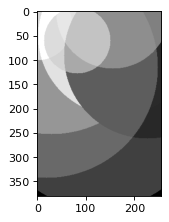

  0%|                                      | 4/350000 [00:00<8:05:25, 12.02it/s]

Sigmas: 
 [[0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05029442 0.05007447 0.05       0.04996343 0.05      ]
 [0.05       0.05       0.05       0.0495952  0.04897688]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.0487023  0.04922332 0.05002355 0.04871305]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.04902956 0.04867933 0.05       0.0488171  0.05037367]
 [0.05       0.05039397 0.05       0.05       0.05      ]]


  0%|                                    | 100/350000 [00:04<4:06:45, 23.63it/s]

Iteration 0100 : best score = 600.11162436, mean score = 601.31318359.


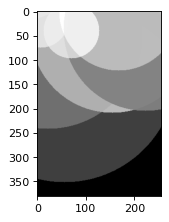

  0%|                                    | 103/350000 [00:04<4:55:52, 19.71it/s]

Sigmas: 
 [[0.04639745 0.05461867 0.04381268 0.05665242 0.04978188]
 [0.04639745 0.05461867 0.04459888 0.05665242 0.05071642]
 [0.04639745 0.05370085 0.04263395 0.05665242 0.05043032]
 [0.04639745 0.05432361 0.04383329 0.05730219 0.04978188]
 [0.04732313 0.0538824  0.04918014 0.05733199 0.04788285]
 [0.04510884 0.05553306 0.04289101 0.05665242 0.04978188]
 [0.04732313 0.0538824  0.04918014 0.05845407 0.04814218]
 [0.04732313 0.0536419  0.04972637 0.058044   0.04814218]
 [0.04639745 0.05560555 0.04412819 0.05498497 0.04995517]
 [0.04652869 0.05697741 0.04743695 0.05512792 0.04800055]
 [0.04639745 0.05461867 0.04412819 0.05665242 0.04978188]
 [0.04639745 0.05560555 0.04401729 0.05481955 0.04964706]
 [0.04625887 0.0538824  0.04918014 0.05743613 0.04828527]
 [0.04732313 0.05319204 0.04918014 0.05844444 0.04814218]
 [0.04732313 0.05319204 0.04918014 0.05863854 0.04814218]
 [0.04458527 0.05458026 0.04412819 0.05481955 0.05002494]]


  0%|                                    | 199/350000 [00:08<3:56:08, 24.69it/s]

Iteration 0200 : best score = 586.38410530, mean score = 586.66947364.


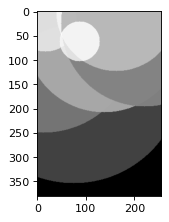

  0%|                                    | 202/350000 [00:08<4:47:35, 20.27it/s]

Sigmas: 
 [[0.05105001 0.05002435 0.0345105  0.05618661 0.05371505]
 [0.05184752 0.04840397 0.03597646 0.05647437 0.05390855]
 [0.05274684 0.04938915 0.0345105  0.05611577 0.05371505]
 [0.0512634  0.04840397 0.03597646 0.05626482 0.05434855]
 [0.04915011 0.04870224 0.03639268 0.05605028 0.05371505]
 [0.05106922 0.0499311  0.03621317 0.05671036 0.05173424]
 [0.0524243  0.04858113 0.03597646 0.05647437 0.05390855]
 [0.04826961 0.04968593 0.03629771 0.05624196 0.05275664]
 [0.05389006 0.04725911 0.03503395 0.05611577 0.05281506]
 [0.04992629 0.0499311  0.03621317 0.056027   0.05261694]
 [0.04896631 0.04885381 0.03587832 0.05674938 0.05371505]
 [0.0512521  0.05258016 0.03339857 0.05618661 0.05371505]
 [0.04907901 0.04968593 0.03639268 0.05605028 0.05371505]
 [0.04915011 0.04929358 0.03639268 0.05628975 0.05350435]
 [0.04992629 0.0499311  0.03591259 0.05605028 0.05371505]
 [0.04826961 0.04939738 0.03589748 0.05642288 0.05275664]]


  0%|                                    | 253/350000 [00:10<4:35:16, 21.18it/s]

Adding circles 1th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.6309297535714575


  0%|                                    | 298/350000 [00:12<3:53:45, 24.93it/s]

Iteration 0300 : best score = 558.19603631, mean score = 558.57941876.


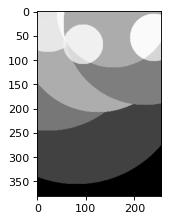

  0%|                                    | 304/350000 [00:12<4:30:13, 21.57it/s]

Sigmas: 
 [[0.05243972 0.04902014 0.03297388 0.05312487 0.04618122]
 [0.05191649 0.05035974 0.03259095 0.05312487 0.04800249]
 [0.0511251  0.05181864 0.03259095 0.05425558 0.04776349]
 [0.05118467 0.05181864 0.03259095 0.05425558 0.04686481]
 [0.05318339 0.04944413 0.03259095 0.05363495 0.04739211]
 [0.05089171 0.05181864 0.03129824 0.05425558 0.04776349]
 [0.05318339 0.04944413 0.03259095 0.05270848 0.04843048]
 [0.05191649 0.05118934 0.03259095 0.05425558 0.04794993]
 [0.0511251  0.05223953 0.03392366 0.05425558 0.0494317 ]
 [0.0511251  0.05181864 0.03259095 0.05425558 0.0494317 ]
 [0.05242151 0.0490603  0.03406322 0.05224837 0.04740175]
 [0.05232818 0.04973635 0.03204092 0.05321672 0.04726236]
 [0.05318339 0.04884653 0.03259095 0.05363495 0.04768258]
 [0.05283379 0.0490603  0.03297388 0.05312487 0.04740175]
 [0.05313885 0.04944413 0.03259095 0.05318505 0.04846164]
 [0.05242956 0.04867469 0.03406322 0.05224837 0.04579577]]


  0%|                                    | 400/350000 [00:16<3:52:24, 25.07it/s]

Adding circles 2th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.43067655807339306
Iteration 0400 : best score = 546.38598900, mean score = 547.77594624.


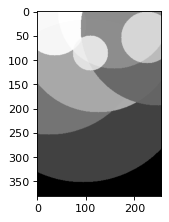

Sigmas: 
 [[0.05890989 0.04998839 0.03201042 0.04593142 0.04653489]
 [0.05852197 0.05238252 0.0333566  0.04612189 0.04649162]
 [0.05852197 0.05220035 0.03304469 0.04668244 0.04672377]
 [0.05907349 0.05238252 0.03479152 0.04579558 0.04649162]
 [0.05852197 0.05238252 0.0333566  0.04593142 0.04649162]
 [0.05852197 0.05125179 0.03285614 0.04593142 0.04649162]
 [0.05852197 0.05238252 0.0333566  0.04612189 0.04649162]
 [0.05852197 0.05109764 0.03458462 0.048101   0.04686424]
 [0.05995478 0.04998839 0.03201042 0.04593142 0.04653489]
 [0.06017072 0.05238252 0.0333958  0.04341791 0.0469584 ]
 [0.05852197 0.05238252 0.0333566  0.04593142 0.04649162]
 [0.05995478 0.04867205 0.03388739 0.04573421 0.04712852]
 [0.05852197 0.05125179 0.0320684  0.04593142 0.04649162]
 [0.05918352 0.04950553 0.03201042 0.04549623 0.04653489]
 [0.05920437 0.05043735 0.03201042 0.04593142 0.04653489]
 [0.05829088 0.0534741  0.03192796 0.04551045 0.04677444]]


  0%|                                    | 499/350000 [00:20<3:47:02, 25.66it/s]

Iteration 0500 : best score = 500.83839395, mean score = 501.59270683.


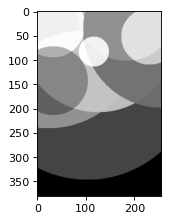

  0%|                                    | 502/350000 [00:21<4:38:00, 20.95it/s]

Sigmas: 
 [[0.0571078  0.04860408 0.03262647 0.04530435 0.04697123]
 [0.05898292 0.04860408 0.03360846 0.04501492 0.04697123]
 [0.0571078  0.04853523 0.03154671 0.04530435 0.04697123]
 [0.0548799  0.04880102 0.03262647 0.04585487 0.04697123]
 [0.05898292 0.04989056 0.03549658 0.04531221 0.04642529]
 [0.05646841 0.04853523 0.03154671 0.04530435 0.04697123]
 [0.05754776 0.04791663 0.03184532 0.04530435 0.04617772]
 [0.05646841 0.04894251 0.03154671 0.04530435 0.04697123]
 [0.05879843 0.04820168 0.03453972 0.04501492 0.04697123]
 [0.05610656 0.04853523 0.03048619 0.04530435 0.04556783]
 [0.05754776 0.04791663 0.03184532 0.04530435 0.04617772]
 [0.05754776 0.0495054  0.03051453 0.04567503 0.0464681 ]
 [0.0571078  0.04863439 0.03262647 0.04494098 0.04575288]
 [0.05646841 0.0495716  0.02923594 0.0449341  0.04582597]
 [0.05690208 0.04860408 0.03163356 0.0437458  0.04697123]
 [0.05586814 0.0495716  0.02923594 0.04542362 0.04582597]]


  0%|                                    | 598/350000 [00:24<3:48:28, 25.49it/s]

Adding circles 3th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.3562071871080222
Iteration 0600 : best score = 494.06224019, mean score = 494.67908048.


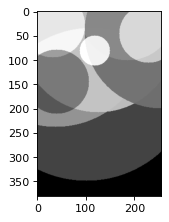

  0%|                                    | 601/350000 [00:25<5:05:43, 19.05it/s]

Sigmas: 
 [[0.05430617 0.04522299 0.02851588 0.04777751 0.0459423 ]
 [0.0518497  0.04605534 0.02979516 0.04755569 0.0464166 ]
 [0.05430617 0.04605534 0.02851588 0.04784816 0.0459423 ]
 [0.05203756 0.04563232 0.02965055 0.04784816 0.04600299]
 [0.05203756 0.04605534 0.02965055 0.04784816 0.04600299]
 [0.05248803 0.04382508 0.03115891 0.04784816 0.04715527]
 [0.05125757 0.04729518 0.0309894  0.04784816 0.04600299]
 [0.05125757 0.04729518 0.03062803 0.04659056 0.04600299]
 [0.05191165 0.04460984 0.03099539 0.04784816 0.04715801]
 [0.05248803 0.04642739 0.03133618 0.04784816 0.04715527]
 [0.05366973 0.04656595 0.02873954 0.04784816 0.04670174]
 [0.05281034 0.04843701 0.02965055 0.04949701 0.04738941]
 [0.05248803 0.04382508 0.03115891 0.04759433 0.04788865]
 [0.05281034 0.04741139 0.02965055 0.04784816 0.04738941]
 [0.05203756 0.04605534 0.02965055 0.04784816 0.04600299]
 [0.05125757 0.04604442 0.02972768 0.04784816 0.04600299]]


  0%|                                    | 700/350000 [00:29<3:48:58, 25.43it/s]

Iteration 0700 : best score = 442.35741946, mean score = 442.85420617.


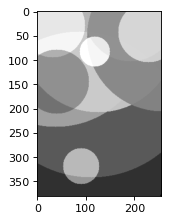

  0%|                                    | 703/350000 [00:29<4:38:12, 20.92it/s]

Sigmas: 
 [[0.05002783 0.04847012 0.02786393 0.05306681 0.04226428]
 [0.05037034 0.04873711 0.02862162 0.05306681 0.04002057]
 [0.05037034 0.04873711 0.02862162 0.05306681 0.04002057]
 [0.05037034 0.04847012 0.02862162 0.05306681 0.04168607]
 [0.04999442 0.0476255  0.02862162 0.05201634 0.04168607]
 [0.04951953 0.04847012 0.02786393 0.05306081 0.04226428]
 [0.04884716 0.0469447  0.02901776 0.05262993 0.04391634]
 [0.04884716 0.0469447  0.02902504 0.05301581 0.04391634]
 [0.05223143 0.04847012 0.02903675 0.05181288 0.04120714]
 [0.04999442 0.04811081 0.02868139 0.05201634 0.04048146]
 [0.05037034 0.04818056 0.02903675 0.05282198 0.04033268]
 [0.04893927 0.0469447  0.02901776 0.05180656 0.04391634]
 [0.04893927 0.0469447  0.02901776 0.05195354 0.04391634]
 [0.04893927 0.0469447  0.02901776 0.05343336 0.04391634]
 [0.05037034 0.04926656 0.02883962 0.05203361 0.0436982 ]
 [0.05037034 0.04722572 0.02862162 0.05306681 0.04043867]]


  0%|                                    | 754/350000 [00:31<4:02:30, 24.00it/s]

Adding circles 4th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.31546487678572877


  0%|                                    | 799/350000 [00:33<3:41:34, 26.27it/s]

Iteration 0800 : best score = 436.07670158, mean score = 436.88568372.


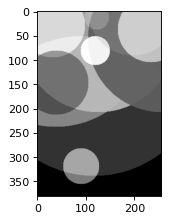

  0%|                                    | 802/350000 [00:33<4:33:15, 21.30it/s]

Sigmas: 
 [[0.04542423 0.04594697 0.02400905 0.04972608 0.04327925]
 [0.04658599 0.04525102 0.02476342 0.05010646 0.04327925]
 [0.04658599 0.04464026 0.02476342 0.05035226 0.04327925]
 [0.04534089 0.0446769  0.02476342 0.04932228 0.0442296 ]
 [0.04532823 0.0446769  0.02476342 0.05010646 0.04327925]
 [0.04678996 0.04413563 0.02476342 0.05010646 0.04327925]
 [0.04858932 0.0454764  0.0272662  0.04941113 0.04377649]
 [0.04658599 0.04525102 0.02476342 0.04953509 0.04273457]
 [0.04535986 0.04701453 0.02476342 0.05022677 0.04256612]
 [0.04549995 0.04525102 0.0236094  0.04904275 0.04327925]
 [0.04658599 0.04701453 0.02476342 0.05053664 0.04273457]
 [0.04658599 0.04647523 0.02591155 0.04977747 0.03963083]
 [0.04858932 0.04621144 0.02562084 0.0500183  0.04377649]
 [0.04658599 0.04525102 0.02510714 0.04884503 0.04310833]
 [0.04689859 0.04565904 0.02476342 0.05010646 0.04327925]
 [0.04858932 0.04621144 0.02580403 0.05074802 0.04395323]]


  0%|                                    | 898/350000 [00:37<3:58:55, 24.35it/s]

Iteration 0900 : best score = 425.75073276, mean score = 426.72734527.


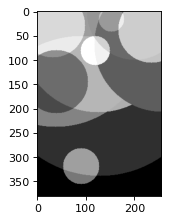

  0%|                                    | 901/350000 [00:37<5:03:15, 19.19it/s]

Sigmas: 
 [[0.04870057 0.04636382 0.02258274 0.04874166 0.04488932]
 [0.04746119 0.0503113  0.02173508 0.04634829 0.04339573]
 [0.04870057 0.04636382 0.02258274 0.04856045 0.04488932]
 [0.04670853 0.0506188  0.02173508 0.04634829 0.04363271]
 [0.04870057 0.04636382 0.02258274 0.04958165 0.04488932]
 [0.0462065  0.04748241 0.02260176 0.04931564 0.04561137]
 [0.0462065  0.04748241 0.02260176 0.04931564 0.04552582]
 [0.0462065  0.04748241 0.02260176 0.04931564 0.04522582]
 [0.0459329  0.04636382 0.0243308  0.04938015 0.04488932]
 [0.04746119 0.0503113  0.02173508 0.04634829 0.04327347]
 [0.0467614  0.04748241 0.02347722 0.04931564 0.04487935]
 [0.04746119 0.0503113  0.02205134 0.04602438 0.04339573]
 [0.04733685 0.04951547 0.02173508 0.04536334 0.04167275]
 [0.04746119 0.04918538 0.02173508 0.04634829 0.04339573]
 [0.04652085 0.04636382 0.02347722 0.04935585 0.04488932]
 [0.04619015 0.04655512 0.02347722 0.04931564 0.04358716]]


  0%|                                    | 952/350000 [00:39<4:46:26, 20.31it/s]

Adding circles 5th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.2890648263178879


  0%|                                   | 1000/350000 [00:41<3:58:16, 24.41it/s]

Iteration 1000 : best score = 415.98023943, mean score = 416.93671749.


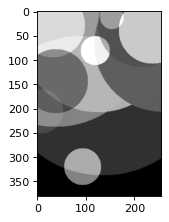

  0%|                                   | 1003/350000 [00:41<5:02:08, 19.25it/s]

Sigmas: 
 [[0.04797656 0.0488177  0.02113649 0.05078148 0.05084656]
 [0.0483194  0.0488177  0.02113649 0.05190586 0.05084656]
 [0.05022262 0.0488177  0.02002748 0.04926416 0.04920021]
 [0.04797656 0.0488177  0.02036952 0.05078148 0.05084656]
 [0.04797656 0.0488177  0.02036952 0.05078148 0.05084656]
 [0.04755813 0.0488177  0.02097652 0.05078148 0.05208583]
 [0.04755813 0.04830621 0.02118344 0.05057704 0.05314473]
 [0.04928156 0.0488177  0.02036952 0.04926416 0.05038035]
 [0.04797656 0.0489654  0.02036952 0.05078148 0.05084656]
 [0.04928156 0.0488177  0.02036952 0.04926416 0.05084656]
 [0.04930346 0.0488177  0.02036952 0.05078148 0.05174264]
 [0.05092549 0.05022835 0.01942851 0.0516104  0.0535126 ]
 [0.05061598 0.05022835 0.01942851 0.05113415 0.0535126 ]
 [0.04797656 0.0488177  0.0193761  0.05079419 0.05101998]
 [0.0515122  0.04948503 0.02002748 0.04926416 0.04920021]
 [0.05061598 0.05022835 0.01942851 0.05113415 0.05151976]]


  0%|                                   | 1099/350000 [00:45<3:53:49, 24.87it/s]

Adding circles 6th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.27023815442731974
Iteration 1100 : best score = 412.17057998, mean score = 412.60094169.


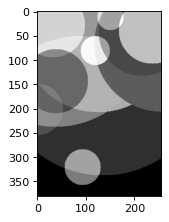

  0%|                                   | 1102/350000 [00:46<5:26:39, 17.80it/s]

Sigmas: 
 [[0.04692708 0.04940941 0.02125381 0.04808639 0.05396004]
 [0.04719446 0.05012472 0.02117757 0.0512521  0.05630775]
 [0.04738843 0.05012472 0.02152319 0.05182608 0.05470281]
 [0.04814617 0.04921738 0.02125381 0.04910018 0.05315589]
 [0.04735065 0.0501963  0.02018229 0.04958797 0.05554689]
 [0.04814617 0.04921738 0.02125381 0.04910018 0.05315589]
 [0.04766035 0.04974547 0.02152319 0.05147877 0.05294535]
 [0.04738843 0.04989345 0.02153294 0.05127726 0.05431423]
 [0.04815449 0.0501963  0.02053539 0.04958797 0.05294535]
 [0.04812939 0.04999801 0.02128852 0.04970216 0.05294461]
 [0.04738843 0.04989345 0.02152319 0.05182608 0.05470281]
 [0.04815839 0.04921738 0.02125381 0.05027145 0.05315589]
 [0.04784895 0.04857719 0.02094127 0.05027145 0.05309414]
 [0.04784895 0.04978896 0.02128852 0.04970216 0.05392959]
 [0.04776186 0.04974547 0.02152319 0.05088358 0.05294535]
 [0.04897736 0.04974981 0.02024892 0.0525791  0.05121787]]


  0%|                                   | 1198/350000 [00:49<3:52:14, 25.03it/s]

Adding circles 7th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.2559580248098155
Iteration 1200 : best score = 407.75856013, mean score = 408.05117882.


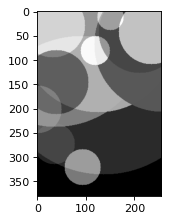

  0%|                                   | 1201/350000 [00:50<5:23:44, 17.96it/s]

Sigmas: 
 [[0.05136157 0.04823751 0.01953608 0.05650463 0.05560702]
 [0.05136157 0.04829735 0.01943433 0.05650463 0.05596571]
 [0.0521022  0.04758788 0.01946077 0.05411407 0.05572671]
 [0.05136157 0.04758788 0.01943433 0.05650463 0.05596571]
 [0.05238013 0.04729292 0.01943433 0.05411407 0.05572671]
 [0.04948247 0.04704034 0.01900151 0.05650463 0.05453756]
 [0.05181252 0.04976718 0.01902771 0.05411407 0.05762638]
 [0.05136157 0.04829735 0.01872373 0.05650463 0.05929163]
 [0.05015011 0.04823751 0.01754505 0.05662168 0.05560702]
 [0.0521022  0.04758788 0.01943433 0.05411407 0.05572671]
 [0.0521022  0.04758788 0.01946077 0.05500114 0.05685662]
 [0.05246762 0.04758788 0.01946618 0.05650463 0.05596571]
 [0.05034323 0.04801218 0.01943433 0.05411407 0.05555722]
 [0.04969705 0.04829735 0.01943433 0.05650463 0.05770087]
 [0.04903674 0.04801218 0.02071354 0.05411407 0.05555722]
 [0.0534451  0.04829735 0.02033698 0.05650463 0.0559319 ]]


  0%|▏                                  | 1300/350000 [00:54<3:50:08, 25.25it/s]

Iteration 1300 : best score = 399.39999171, mean score = 399.74934962.


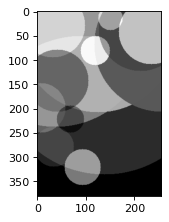

  0%|▏                                  | 1303/350000 [00:54<4:55:09, 19.69it/s]

Sigmas: 
 [[0.04791678 0.05300985 0.01865813 0.05101424 0.05299509]
 [0.04882635 0.05165473 0.01943026 0.05101424 0.05299509]
 [0.04882635 0.05165473 0.01943026 0.05113893 0.05299509]
 [0.04853407 0.05165473 0.01847211 0.05011902 0.05299509]
 [0.0486631  0.05261763 0.01863131 0.05101745 0.05299509]
 [0.04882635 0.05165473 0.0195148  0.05101745 0.05299509]
 [0.04853407 0.05165473 0.01943026 0.05011902 0.05299509]
 [0.0490701  0.05165473 0.01847211 0.05014723 0.05362754]
 [0.04882635 0.05165473 0.01943026 0.05113893 0.05427936]
 [0.04853407 0.05165473 0.01818628 0.05011902 0.05349915]
 [0.0485573  0.05165473 0.01943026 0.05113893 0.05381893]
 [0.04855971 0.05165473 0.01809418 0.05011902 0.05349915]
 [0.04897731 0.05190194 0.01943026 0.05175795 0.05299509]
 [0.04772369 0.05204354 0.02144856 0.04801684 0.05265577]
 [0.04828318 0.05197308 0.02144856 0.04801684 0.05356051]
 [0.05074019 0.05197308 0.02152162 0.04919246 0.05345868]]


  0%|▏                                  | 1354/350000 [00:56<4:12:43, 22.99it/s]

Adding circles 8th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.24465054211822604


  0%|▏                                  | 1399/350000 [00:58<3:52:40, 24.97it/s]

Iteration 1400 : best score = 395.80940563, mean score = 396.53762601.


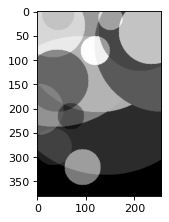

  0%|▏                                  | 1402/350000 [00:58<5:19:10, 18.20it/s]

Sigmas: 
 [[0.05307695 0.05248892 0.01637591 0.05428194 0.05125276]
 [0.04983881 0.05119062 0.0168047  0.05483513 0.05086139]
 [0.05151204 0.05248892 0.01637591 0.05444396 0.05157671]
 [0.04983881 0.05119062 0.01777797 0.05478906 0.05023458]
 [0.0509505  0.0522242  0.01470368 0.05483513 0.05086139]
 [0.05120155 0.05189436 0.01619443 0.05444396 0.05086139]
 [0.04999839 0.05189436 0.01619443 0.05483513 0.05086139]
 [0.04983881 0.05119062 0.01638486 0.05523108 0.04966568]
 [0.05151204 0.05288423 0.01637591 0.05610491 0.05111839]
 [0.05120155 0.05248892 0.01619443 0.05444396 0.05235565]
 [0.04983881 0.05004405 0.01777797 0.05478906 0.05035922]
 [0.05151204 0.05248892 0.01637591 0.05444396 0.0525003 ]
 [0.04983881 0.05119062 0.01607276 0.05483513 0.05206874]
 [0.0520144  0.05288423 0.01598045 0.05610491 0.05111839]
 [0.05120155 0.05180427 0.01619443 0.05439266 0.05235565]
 [0.05120155 0.05189436 0.01619443 0.05444396 0.05235565]]


  0%|▏                                  | 1453/350000 [01:00<4:23:28, 22.05it/s]

Adding circles 9th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.23540891336663824


  0%|▏                                  | 1498/350000 [01:02<3:49:53, 25.27it/s]

In [ ]:
best_solution_objective_value, best_solution, best_solution_background,\
log_objective_values, log_best_solutions, log_best_backgrounds , \
log_sigmas_mean = es_model.train(
                                  number_of_iterations=350000,
                                  number_of_parents=6, 
                                  number_of_offspring_per_parent=3, 
                                  max_chromosome_length=256,
                                  initial_sigma_scale=5e-2,
                                  add_cricle_threshold=1e-2,
                                  log_frequency=100,
                                  update_frequency=50
    )

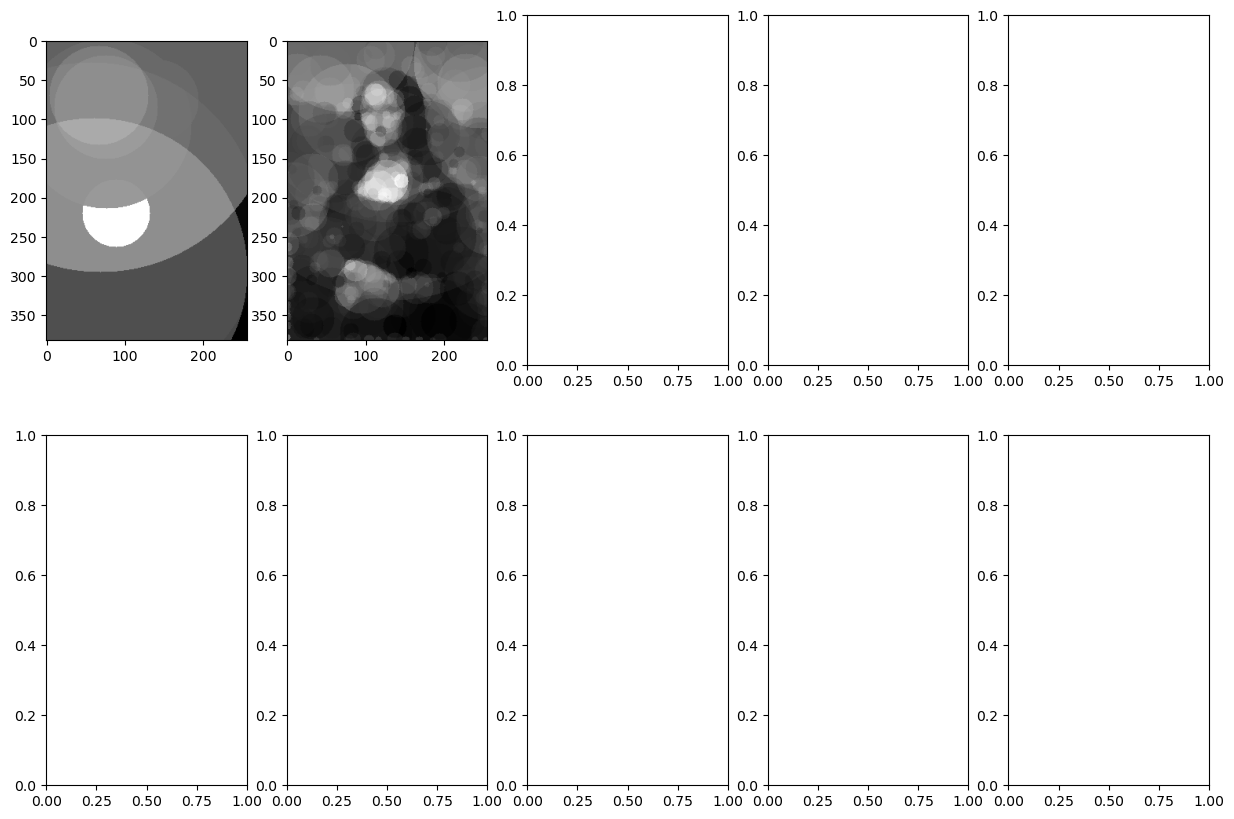

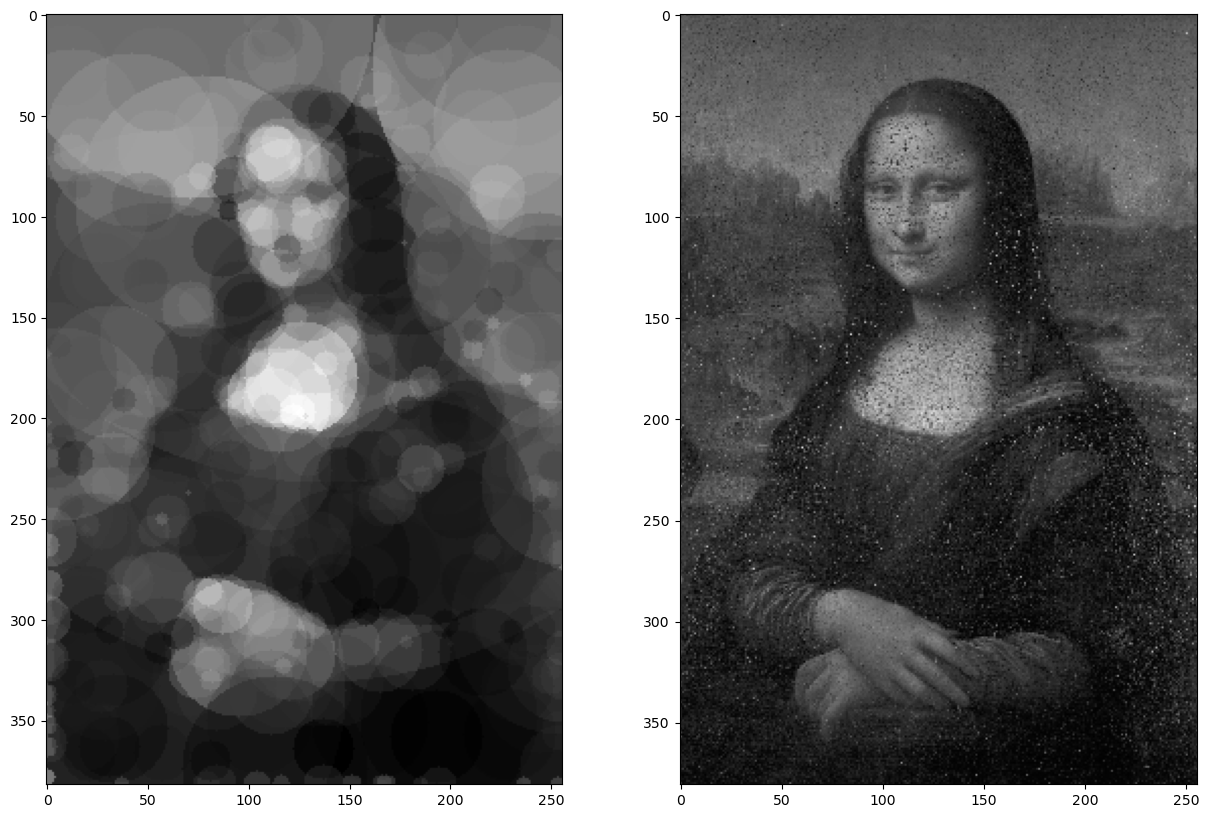

In [57]:
#mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
   # if i%mod_val==0:
        axs[row_counter, col_counter].imshow(es_model.represent_individual(X, log_best_backgrounds[i]), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(es_model.represent_individual(best_solution, best_solution_background), cmap='gray')
axs[1].imshow(es_model.target_img, cmap='gray')
plt.show()

/tmp/ipykernel_3023347/819793694.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(log_objective_values[:,0]))


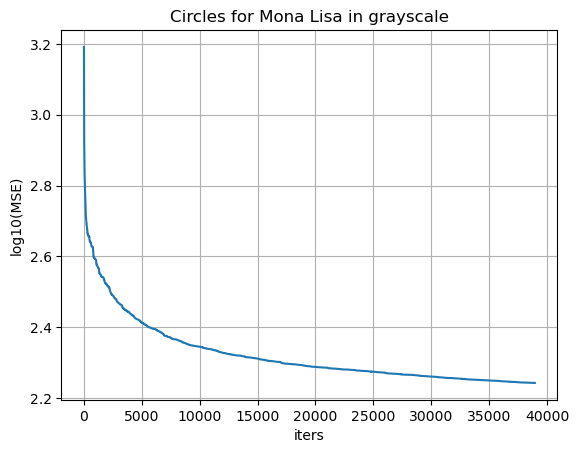

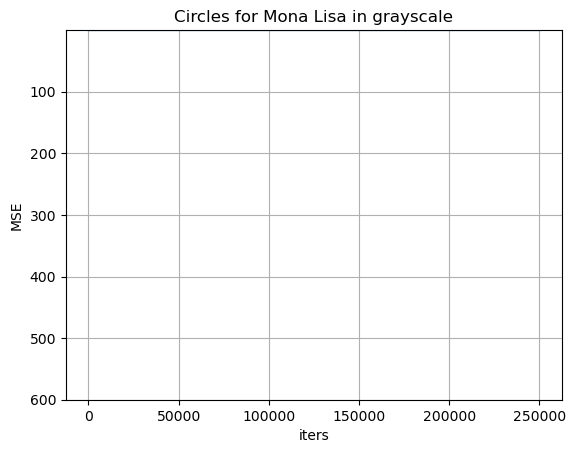

In [54]:
plt.plot(np.log10(log_objective_values[:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('log10(MSE)')
plt.xlabel('iters')

plt.show()

plt.plot(log_objective_values[100000:,2])
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('MSE')
plt.xlabel('iters')
plt.ylim(bottom=600)

plt.show()

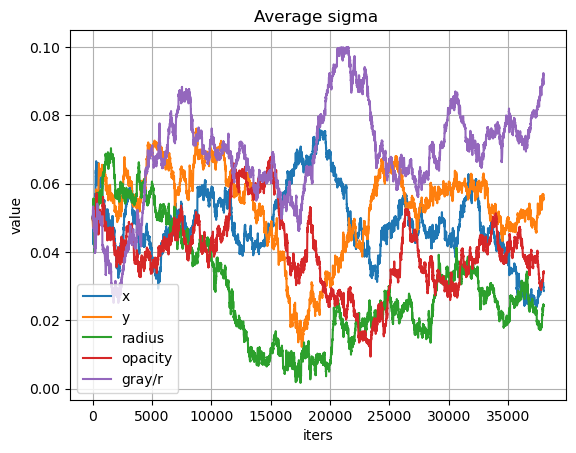

In [56]:
sigmas_params={0:'x', 1:'y', 2:'radius', 3:'opacity', 4:'gray/r', 5:'g', 6:'b'}

for i in range(es_model.genotype_length):
    plt.plot(log_sigmas_mean[:38000,i], label=sigmas_params[i])

plt.grid()
plt.title("Average sigma ")
plt.ylabel('value')
plt.xlabel('iters')
plt.legend()

plt.show()